In [4]:
import math
import re
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
# Q1
#loading the datasets
gold = pd.read_csv('gold.txt',sep = "\t", header = None, names = ["URL", "Category"])
labels = pd.read_csv('labels.txt',sep = "\t", header = None, names = ["Turk","URL", "Category"])
gold.head()
labels.head()

,Turk,URL,Category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G


In [29]:
#Q2
#splitting labels into two dataframes
labels_on_gold = labels[labels['URL'].isin(gold['URL'])]
labels_unknown = labels[labels['URL'].isin(gold['URL']) == False]

In [35]:
# Q3 
# compute accuracies of turks
responsecheck = labels_on_gold.merge(gold, left_on = "URL", right_on = "URL", suffixes = ["_response", "_correct"])
responsecheck['Correct'] = 0
responsecheck.loc[responsecheck['Category_response'] == responsecheck['Category_correct'],'Correct'] = 1

def accuracy(x):
    return x.sum()/x.count()

rater_goodness = responsecheck.groupby('Turk')[['Correct']].agg(accuracy)
rater_goodness.head()

C:\Users\ashis\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


,Correct
Turk,
A112DVP1KG4QZU,1.000000
A1253FXHCZ9CWM,0.517241
A12CY1Q7XKJJDE,1.000000
A12RE8G66WTO8B,0.750000
A12Y1GTGIQDGRA,0.333333


In [38]:
# Q4
rater_goodness['odds'] = rater_goodness['Correct']/(1.001-rater_goodness['Correct'])
rater_goodness.head()

,Correct,odds
Turk,,
A112DVP1KG4QZU,1.000000,1000.000000
A1253FXHCZ9CWM,0.517241,1.069214
A12CY1Q7XKJJDE,1.000000,1000.000000
A12RE8G66WTO8B,0.750000,2.988048
A12Y1GTGIQDGRA,0.333333,0.499251


In [42]:
# Q5
rater_goodness2 = responsecheck.groupby('Turk')[['Correct']].agg(['sum', 'count',accuracy])
rater_goodness2[rater_goodness2['Correct']['count'] >=20]['Correct'].sort_values(by = ["accuracy","count"], ascending = False)[:10].index


rater_goodness2['odds'] = rater_goodness2['Correct']['accuracy']/(1.001-rater_goodness2['Correct']['accuracy'])
rater_goodness2

C:\Users\ashis\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


Correct                         odds
                   sum count  accuracy             
Turk                                               
A112DVP1KG4QZU       1     1  1.000000  1000.000000
A1253FXHCZ9CWM      15    29  0.517241     1.069214
A12CY1Q7XKJJDE       1     1  1.000000  1000.000000
A12RE8G66WTO8B      15    20  0.750000     2.988048
A12Y1GTGIQDGRA       1     3  0.333333     0.499251
...                ...   ...       ...          ...
AYWOBMTEGFVVI        0     1  0.000000     0.000000
AZ1S5BIG5R6P6       25    35  0.714286     2.491281
AZSDW7JJL5VA7       68   100  0.680000     2.118380
AZVB3RZW0OR1H        2     3  0.666667     1.994018
amurray             14    15  0.933333    13.793103

[269 rows x 4 columns]

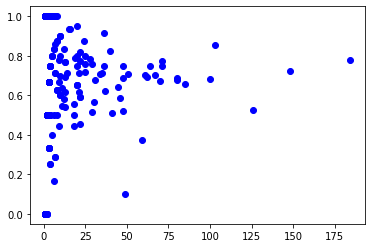

In [11]:
# Q6
plot(rater_goodness2['Correct']['count'],rater_goodness2['Correct']['accuracy'], marker = "o", color = "blue", linestyle = "None")

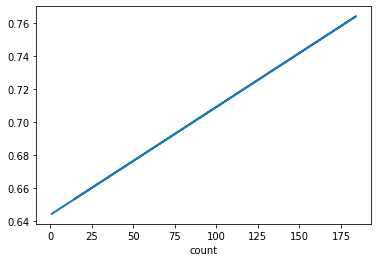

In [12]:
import statsmodels.api as sm
from patsy import dmatrices
y, x = dmatrices('accuracy~count', rater_goodness2['Correct'], return_type = "dataframe")
result = sm.OLS(y,x).fit()
slope = result.params['count']
intercept = result.params['Intercept']
pred = rater_goodness2['Correct']['count']*slope+intercept
reg_pred = Series(pred.values, index = rater_goodness2['Correct']['count'])
reg_pred.plot(label = "Regression", linewidth = 2)

In [13]:
result.rsquared

0.0020234379410812853

In [14]:
result.pvalues

Intercept    1.163240e-78
count        4.625183e-01
dtype: float64

In [11]:
##With linear regression we get a positive slope, but with a very low r-square along with a very high p-value for the intercept. This might be because of the outliers/ high leverage points we see in the spread above. Thus it's highly unlikely that more answers would mean better accuracy. From the spread it gives counter intution that it's more likely if a person is giving selective answers he might have higher accuracy, but if a person rates more his accuracy drops a bit due to some incorrect answers but it still doesn't drop to a very low accuracy rate.

In [15]:
def product(x):
    return x.product()

In [45]:
# Q7
labels_unknown_odds = labels_unknown.merge(DataFrame(rater_goodness2['Correct']).reset_index(), left_on = "Turk", right_on = "Turk", suffixes=['_unknown', '_goldset'])
labels_unknown_odds = labels_unknown_odds.merge(DataFrame(rater_goodness2['odds']).reset_index(), left_on = "Turk", right_on = "Turk", suffixes=['_unknown', '_goldset'])
y1 = rater_goodness2['Correct']['count'].quantile(0.75)
labels_unknown_odds = labels_unknown_odds[labels_unknown_odds['count']>=y1]
categoryodds = labels_unknown_odds.groupby(['URL', 'Category'])[['odds']].agg(product).reset_index()
categoryodds['odds'].sum()

9858557.000337768

In [48]:
# Q8
result_75_new = categoryodds.sort_values(by = 'odds', ascending = False).drop_duplicates(subset = 'URL')
result_75_new.rename(columns = {'Category':'Top category', 'odds':'Top odds'}, inplace = True)
result_75_new['Top odds'].sum()

9847889.623624476

In [52]:
# Q9
labels_unknown_odds = labels_unknown.merge(DataFrame(rater_goodness2['Correct']).reset_index(), left_on = "Turk", right_on = "Turk", suffixes=['_unknown', '_goldset'])
labels_unknown_odds = labels_unknown_odds.merge(DataFrame(rater_goodness2['odds']).reset_index(), left_on = "Turk", right_on = "Turk", suffixes=['_unknown', '_goldset'])
y2 = rater_goodness2['Correct']['count'].quantile(0.25)
labels_unknown_odds = labels_unknown_odds[labels_unknown_odds['count']>=y2]
categoryodds2 = labels_unknown_odds.groupby(['URL', 'Category'])[['odds']].agg(product).reset_index()
categoryodds2

,URL,Category,odds
0,http://0-101.net,G,2.155963e+00
1,http://000.cc,G,2.181050e+03
2,http://000.cc,P,9.980040e-01
3,http://0000.jp,G,2.877556e+07
4,http://000relationships.com,G,0.000000e+00
...,...,...,...
17789,http://zz868.com,G,1.209566e+16
17790,http://zz868.com,P,1.851852e+00
17791,http://zzx.cc,G,1.330229e+00
17792,http://zzx.cc,P,9.980040e-01


In [55]:
result_25_new = categoryodds2.sort_values(by = 'odds', ascending = False).drop_duplicates(subset = 'URL')
result_25_new.rename(columns = {'Category':'Top category', 'odds':'Top odds'}, inplace = True)
result_25_new

,URL,Top category,Top odds
6107,http://electriqueboutique.com,P,6.437853e+18
2850,http://bharatstudent.com,G,1.006383e+17
5793,http://ds-collection.net,G,2.560230e+16
16989,http://webpandora.ru,G,2.560230e+16
1052,http://acmelove.com,P,1.503598e+16
...,...,...,...
5270,http://delavo.com,G,0.000000e+00
5269,http://delaverianmarketing.com,G,0.000000e+00
5259,http://defence.lk,G,0.000000e+00
5250,http://deeshaa.org,G,0.000000e+00


In [56]:
final_results2 = result_75_new.merge(result_25_new, left_on = 'URL', right_on = 'URL', suffixes = ['_25', '_75'])
final_comparison2 = pd.pivot_table(final_results2, index = 'Top category_75', columns = 'Top category_25', values = 'URL', aggfunc = 'count')
final_comparison2

Top category_25,G,P,R,X
Top category_75,,,,
G,7817,223,22,70
P,886,268,36,12
R,293,65,120,35
X,273,26,35,429
